# Arxiv Dataset Clustering
This notebook aims to cluster scholarly articles from the Arxiv dataset.

# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Load and Preview Data

In [5]:
input_file = '../data/data_preprocessed.csv'
df = pd.read_csv(input_file)
print(df.shape[0])
df.head()

900882


,update_date,text,categories_list,num_categories
0,2022-03-31,convergence discrete dipole approximation theo...,"['physics.optics', 'physics.comp-ph']",2
1,2022-03-30,discrete dipole approximation overview develop...,"['physics.optics', 'physics.comp-ph']",2
2,2021-10-15,mapping radius metric space every closed curve...,['math.MG'],1
3,2019-08-19,remnant evolution carbon oxygen white dwarf me...,['astro-ph'],1
4,2019-08-19,cofibrations category frolicher space cofibrat...,['math.AT'],1


## Text Vectorization

In [6]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,   # Limit the number of features
    sublinear_tf=True     # Apply sublinear scaling
)

# Fit and transform the text data to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text'])

In [7]:
# Show top 50 features (unigrams and bigrams)
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
sorted_indices = np.argsort(tfidf_vectorizer.idf_)
top_features = feature_names[sorted_indices[:50]]
top_features_df = pd.DataFrame(top_features, columns=['Top 50 Features'])
print(top_features_df)

   Top 50 Features
0             data
1         learning
2            field
3          network
4            space
5        algorithm
6           energy
7      information
8         property
9       experiment
10             ing
11         dynamic
12     application
13    distribution
14     dimensional
15         several
16        equation
17         quantum
18        existing
19          linear
20          neural
21       parameter
22        compared
23           multi
24           image
25            rate
26     interaction
27        training
28            deep
29           small
30         complex
31           local
32          source
33         density
34        function
35        accuracy
36       condition
37         feature
38           state
39            mass
40          domain
41        standard
42        datasets
43          sample
44            size
45      prediction
46           limit
47            lead
48            mean
49        provides


## Dimensionality Reduction

In [8]:
# Apply PCA
pca = PCA(n_components=150)  # Choose the number of components
pca_matrix = pca.fit_transform(tfidf_matrix.toarray())

## Determine Optimal Clusters

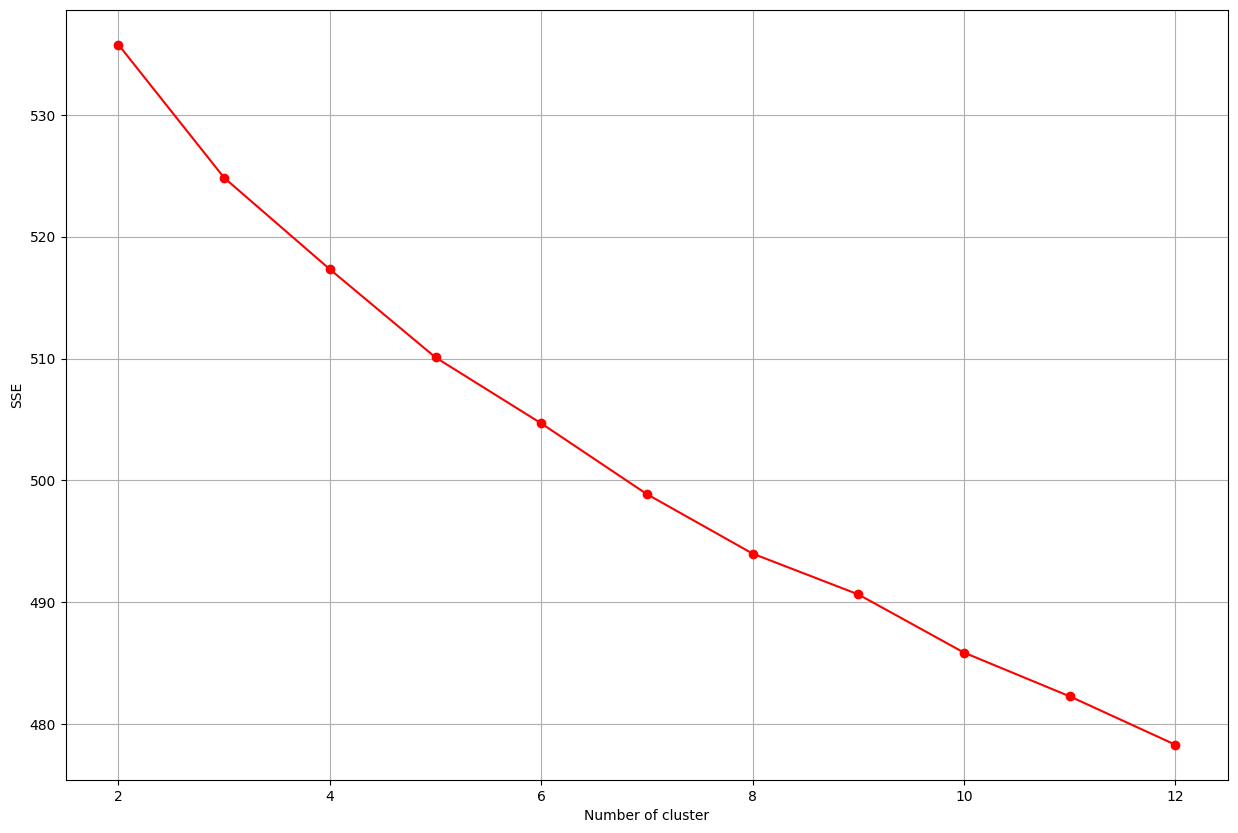

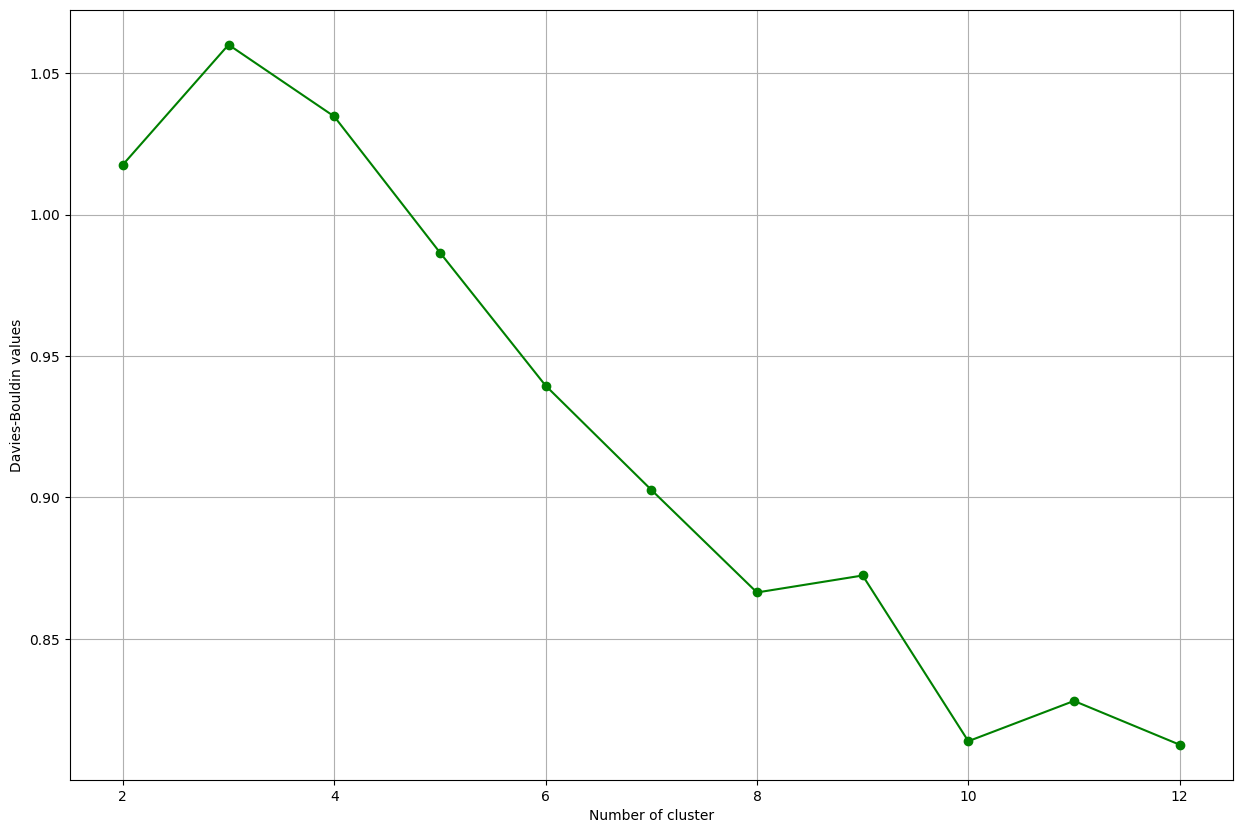

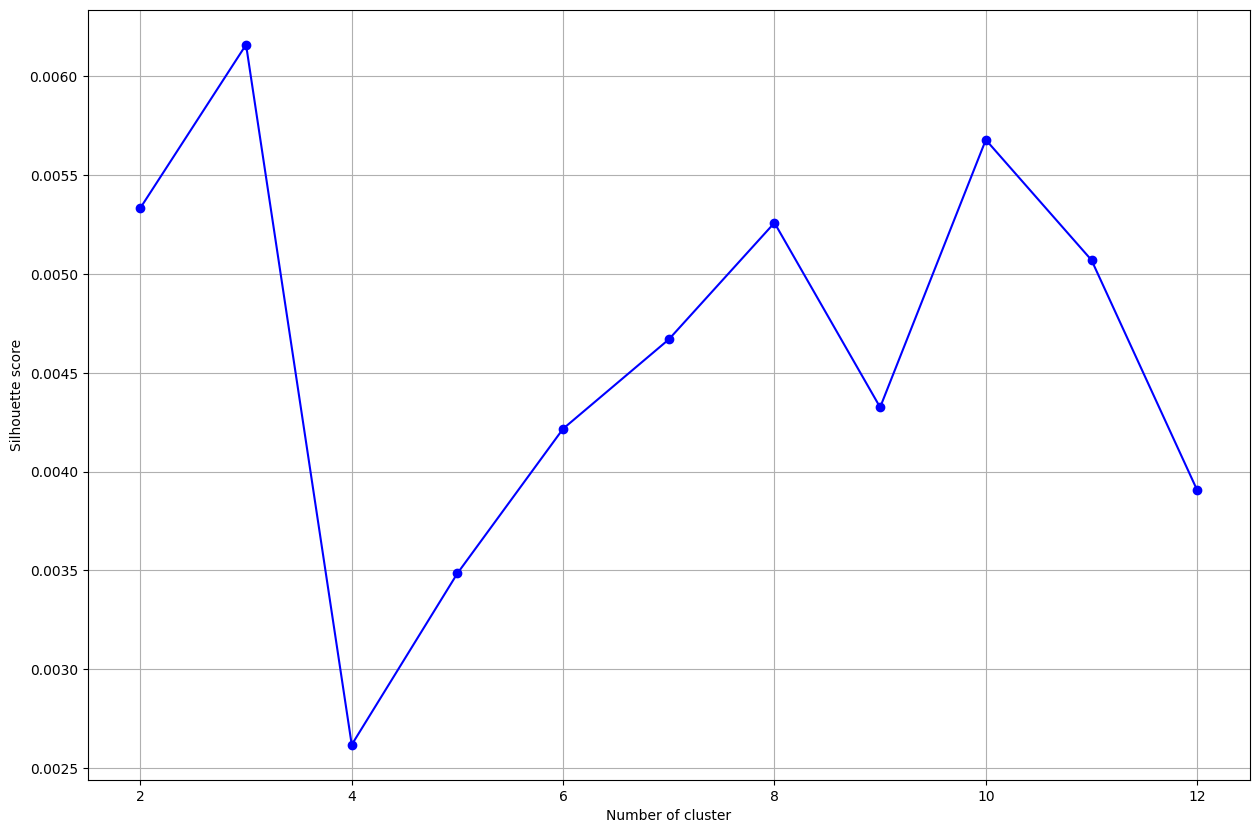

In [10]:
def check_clustering(X, K, n_runs=5):
    avg_sse, avg_db, avg_slc = {}, {}, {}
    
    for _ in range(n_runs):
        np.random.seed(42)  # Setting random seed for reproducibility
        sample_indices = np.random.choice(X.shape[0], int(0.01 * X.shape[0]), replace=False)
        X_sample = X[sample_indices]
        
        sse, db, slc = {}, {}, {}
        for k in range(2, K):
            kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42, n_init=10).fit(X_sample)
            clusters = kmeans.labels_
            
            sse[k] = sse.get(k, 0) + kmeans.inertia_
            db[k] = db.get(k, 0) + davies_bouldin_score(X_sample, clusters)
            slc[k] = slc.get(k, 0) + silhouette_score(X_sample, clusters)
            
        for k in range(2, K):
            avg_sse[k] = sse[k] / n_runs
            avg_db[k] = db[k] / n_runs
            avg_slc[k] = slc[k] / n_runs


    plt.figure(figsize=(15,10))
    plt.plot(list(avg_sse.keys()), list(avg_sse.values()), marker='o', linestyle='-', color='r')
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.grid(True)
    plt.savefig('../images/clustering/sse.png')
    plt.show()

    plt.figure(figsize=(15,10))
    plt.plot(list(avg_db.keys()), list(avg_db.values()), marker='o', linestyle='-', color='g')
    plt.xlabel("Number of cluster")
    plt.ylabel("Davies-Bouldin values")
    plt.grid(True)
    plt.savefig('../images/clustering/Davies-Bouldin.png')
    plt.show()

    plt.figure(figsize=(15,10))
    plt.plot(list(avg_slc.keys()), list(avg_slc.values()), marker='o', linestyle='-', color='b')
    plt.xlabel("Number of cluster")
    plt.ylabel("Silhouette score")
    plt.grid(True)
    plt.savefig('../images/clustering/silhouette.png')
    plt.show()


# Call the function to check clustering
check_clustering(pca_matrix, 13)

## Apply Clustering

In [11]:
def apply_clustering(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = kmeans.fit_predict(X)
    return clusters

optimal_clusters = 8  # Adjusted based on observation.
df['cluster'] = apply_clustering(pca_matrix, optimal_clusters)

## Visualizing Clusters

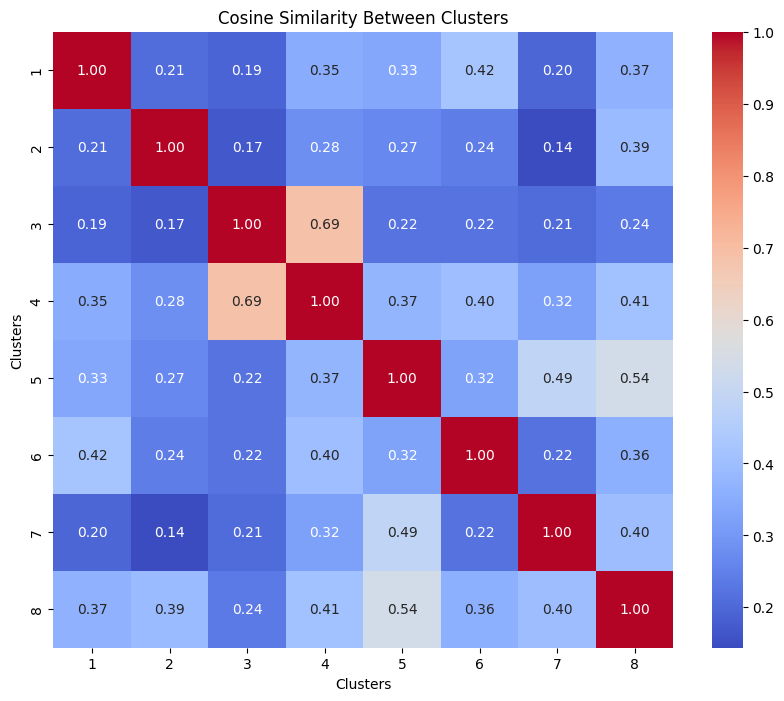

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

# Combine all texts in each cluster
cluster_texts = df.groupby('cluster')['text'].apply(' '.join)

# Compute TF-IDF vectors for each cluster's combined texts
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(cluster_texts)

# Compute cosine similarity between clusters
similarity_matrix = cosine_similarity(tfidf_matrix)


plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=['1','2','3','4','5','6','7','8'], yticklabels=['1','2','3','4','5','6','7','8'])
plt.title('Cosine Similarity Between Clusters')
plt.xlabel('Clusters')
plt.ylabel('Clusters')
plt.savefig('../images/clustering/cosine_similarity.png')
plt.show()

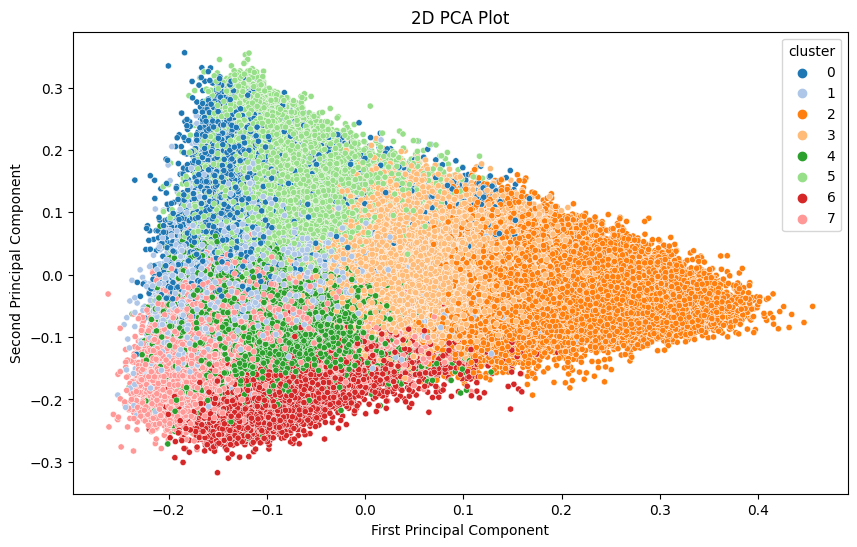

In [14]:
# 2. PCA Plot (2D)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_matrix[:, 0], y=pca_matrix[:, 1], hue=df['cluster'], palette='tab20', s=20)
plt.title('2D PCA Plot')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.savefig('../images/clustering/2d_pca.png')
plt.show()

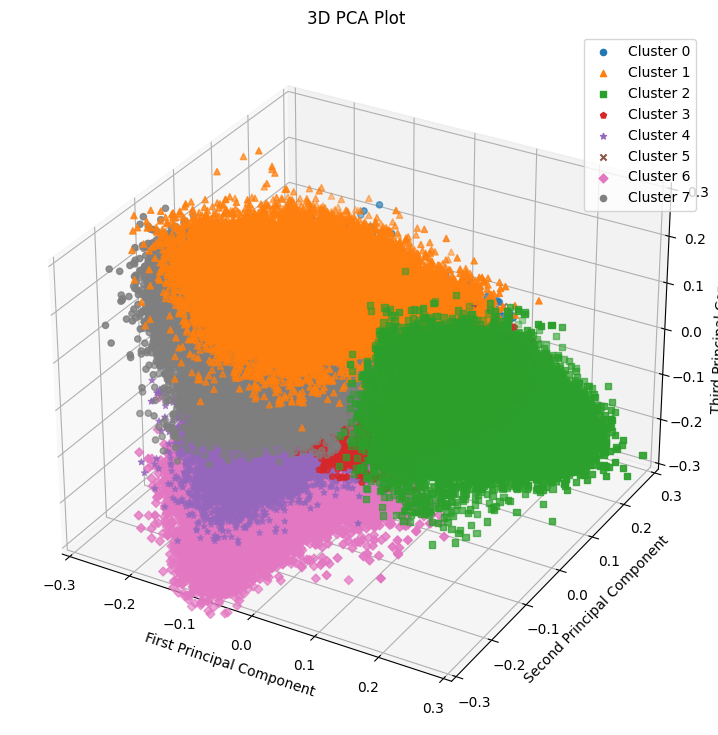

In [15]:
# Initialize a 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Number of clusters
n_clusters = np.max(df['cluster']) + 1  # cluster numbers start from 0

# Different marker styles
markers = ['o', '^', 's', 'p', '*', 'x', 'D']

# Scatter plot with legends
for i in range(n_clusters):
    subset = pca_matrix[df['cluster'] == i]
    ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], label=f'Cluster {i}', marker=markers[i % len(markers)])

# To zoom in
ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.3, 0.3])
ax.set_zlim([-0.3, 0.3])

# Add labels and title
ax.set_title('3D PCA Plot')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

# Add a legend to indicate cluster numbers
ax.legend()

plt.savefig('../images/clustering/3d_pca.png')
plt.show()


## Save Results

In [16]:
output_file = '../data/data_clustered.csv'
df.to_csv(output_file, index=False)